## 🌐 **Google Drive Connection**

In [1]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # select kaggle.json from your pc, using the API from user->setting in KAGGLE (create new token)

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Percorso di destinazione sul Drive
dataset_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")

Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Mounted at /content/drive
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Profiling library
!pip install -U ydata-profiling
from ydata_profiling import ProfileReport

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy.stats import skew


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


📥 Downloading pirate_pain_test.csv ...
 75% 94.0M/125M [00:00<00:00, 980MB/s]
100% 125M/125M [00:00<00:00, 1.00GB/s]
📥 Downloading pirate_pain_train.csv ...
 63% 38.0M/60.8M [00:00<00:00, 395MB/s]
100% 60.8M/60.8M [00:00<00:00, 512MB/s]
📥 Downloading pirate_pain_train_labels.csv ...
  0% 0.00/7.97k [00:00<?, ?B/s]
100% 7.97k/7.97k [00:00<00:00, 13.0MB/s]

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


In [4]:
df_training = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))
df_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))

## 🔎 **Data exploration and profiling**

In [ ]:
data_profile = ProfileReport(df_training, title="Profiling Report")
data_profile

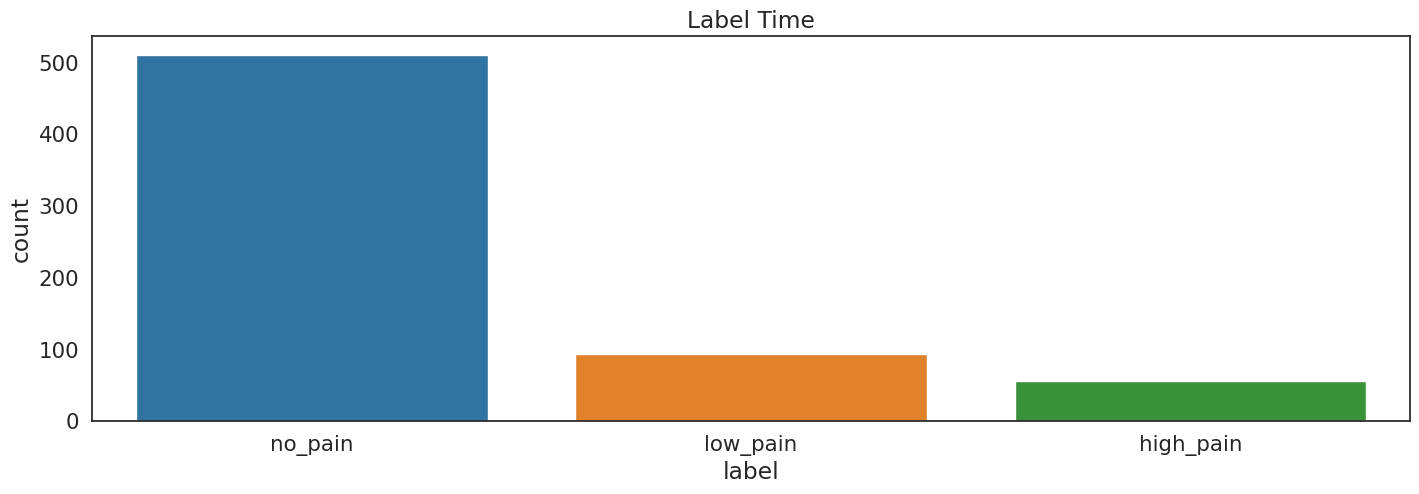

In [5]:
# Visualise the count of time for each label
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df_labels,
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Time')

# Display the plot
plt.show()

In [ ]:
# Count the time for each pirates
time_for_index = df_training.groupby('sample_index').size()
print('Time step for each pirates:\n', time_for_index.value_counts())

Time step for each pirates:
 160    661
Name: count, dtype: int64


In [ ]:
# What do we know about the dataset
#
# - The number of pirates (sample_index → ID) is 661.
# - For each ID, the number of time steps is 160.
#
# We have the joint_x features, which are continuous variables:
# - joint_30 has a constant value across the entire dataset.
# - joint_08, joint_09, joint_10, joint_11, and joint_12 each have unique values for all samples.
#   Since the model cannot learn any meaningful pattern from such features, we drop them.
# - The other joint_x features have poor distributions: most entries are close to zero,
#   while a few outliers are several orders of magnitude higher (around 10^6).
#
# The three features n_legs, n_eyes, and n_hands contain values such as "two" or specific names.
# Only 8 IDs have values different from "two", and for those IDs, all three columns are always different.
# Therefore, we decide to drop these three columns and add a new binary column called "is_injured".
# We should, however, discuss the validity of this choice: it works for our current dataset,
# but if the test set contains a pirate ID where only one or two of these features differ,
# the model’s interpretation might be inconsistent.
#
# The pain_survey_x features have discrete values in [0, 1, 2],
# and we simply convert them to float32 for model compatibility.


## 🧹 **Data cleaning**

In [6]:
# Dataset cleaning and conversion
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
for col in joint_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('float32')

for col in ['pain_survey_1','pain_survey_2','pain_survey_3','pain_survey_4']:
    df_training[col] = df_training[col].astype('float32')

df_training['is_injured'] = np.where(df_training['n_legs'] != 'two', 1, 0).astype('float32')

# Drop useless columns
cols_to_drop = [
    'joint_30',     #constant
    'n_legs', 'n_hands', 'n_eyes',  # replaced by injury_level
    #'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12'  # unique values
]
df_training = df_training.drop(columns=[c for c in cols_to_drop if c in df_training.columns])

# create a single dataset with the labels associated
df = df_training.merge(df_labels, on='sample_index', how='left')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   joint_00       105760 non-null  float32
 7   joint_01       105760 non-null  float32
 8   joint_02       105760 non-null  float32
 9   joint_03       105760 non-null  float32
 10  joint_04       105760 non-null  float32
 11  joint_05       105760 non-null  float32
 12  joint_06       105760 non-null  float32
 13  joint_07       105760 non-null  float32
 14  joint_08       105760 non-null  float32
 15  joint_09       105760 non-null  float32
 16  joint_10       105760 non-null  float32
 17  joint_11       105760 non-nul

In [ ]:
# Update dataset
data_profile = ProfileReport(df_training, title="Profiling Report")
data_profile

## 🛠️ **Model Building**

In [7]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=40, stride=20):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []
    features = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4' ,'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06',
                'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18',
                'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25',
                'joint_26', 'joint_27', 'joint_28', 'joint_29', 'is_injured']

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # sort values
        temp_df = df[df['sample_index'] == id].sort_values('time')

        # Extract data for the current ID
        temp = temp_df[features].values

        # Retrieve the label for the current ID
        label = temp_df['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = (window - len(temp) % window) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(features)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [8]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [9]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [10]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='RNN',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

## 🧠 **Model Training**

In [11]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # gradient clipping
        grad_clip = 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [12]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [13]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [14]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [15]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, val_percent, test_percent, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        val_percent: Number of users for validation set
        test_percent: Number of users for test set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get model architecture parameters
    features = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4' ,'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06',
                'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12','joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18',
                'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25',
                'joint_26', 'joint_27', 'joint_28', 'joint_29', 'is_injured']
    in_features = len(features)
    num_classes = len(df['label'].unique())

    # Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique IDs and shuffle them with split-specific seed
        unique_users = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        n_test_users = round(test_percent * len(unique_users))
        n_val_users = round(val_percent * (len(unique_users) - n_test_users))

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users - n_test_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]
        test_users = unique_users[n_train_users + n_val_users:]

        # Split the dataset into training, validation, and test sets based on user IDs
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val = df[df['sample_index'].isin(val_users)].copy()
        ## df_test = df[df['sample_index'].isin(test_users)].copy()

        # Define a mapping of activity names to integer labels
        label_mapping = {
            'no_pain': 0,
            'low_pain': 1,
            'high_pain':2,
        }

        # Map activity names to integers in the training set
        df_train['label'] = df_train['label'].map(label_mapping)

        # Map activity names to integers in the validation set
        df_val['label'] = df_val['label'].map(label_mapping)

        # Map activity names to integers in the test set
        ## df_test['label'] = df_test['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")
            ## print(f"  Test set shape: {df_test.shape}")

        # ------ Use robust Scaler and log1p ------

        # Correction of skew distributions and scaling
        num_cols = features
        normal_cols = []
        transformable_cols = []
        extreme_cols = []

        train_stats = {}

        for col in features:
            s = skew(df_train[col].dropna())
            q_low = df_train[col].quantile(0.01)
            q_high = df_train[col].quantile(0.99)
            train_stats[col] = {'skew': s, 'q_low': q_low, 'q_high': q_high, 'min': df_train[col].min()}

            if abs(s) < 2:
                normal_cols.append(col)
            elif 2 <= abs(s) <= 10:
                transformable_cols.append(col)
            else:
                extreme_cols.append(col)

        # === (1) Clipping + (2) Log-transform (train and apply to val/test) ===
        for col in transformable_cols + extreme_cols:
              m = train_stats[col]['min']
              q_low = train_stats[col]['q_low']
              q_high = train_stats[col]['q_high']

              # Train
              df_train[col] = df_train[col].clip(q_low, q_high)
              df_train[col] = np.log1p(df_train[col] - m + 1e-6)

              # Validation
              if col in df_val.columns:
                  df_val[col] = df_val[col].clip(q_low, q_high)
                  df_val[col] = np.log1p(df_val[col] - m + 1e-6)

              # Test
              # if col in df_test.columns:
              #     df_test[col] = df_test[col].clip(q_low, q_high)
              #     df_test[col] = np.log1p(df_test[col] - m + 1e-6)

        # === Robust scaling (fit on train, transform val/test) ===
        scaler = RobustScaler()
        df_train[features] = scaler.fit_transform(df_train[features])
        df_val[features] = scaler.transform(df_val[features])
        ## df_test[features] = scaler.transform(df_test[features])

        # -------------------------------------------

        # Build sequences using the existing build_sequences function
        X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
        X_val, y_val = build_sequences(df_val, window=window_size, stride=stride)
        ## X_test, y_test = build_sequences(df_test, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            ## print(f"  Test sequences shape: {X_test.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
        ## test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
        ## test_loader  = make_loader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # ---- Compute class weights dynamically based on training set ----
        label_counts = df_train['label'].value_counts().sort_index()
        class_counts = torch.tensor(label_counts.values, dtype=torch.float)
        class_weights = class_counts.sum() / (class_counts + 1e-6)  # avoid zero
        class_weights = class_weights / class_weights.sum()  # normalization
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [18]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
# RNN baseline

In [17]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 80        # Input window size
STRIDE = 10              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [19]:
%%time
# 20 fa schifo , 80 era il migliore con 0.8909
#W_SIZE = [20, 40, 80, 100]
S_tride = [10] # with 80 W_size -> 10 is better
for STRIDE in S_tride:
  # Execute K-fold cross-validation with baseline configuration
  losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
      df=df,
      epochs=EPOCHS,
      criterion=criterion,
      device=device,
      k=K,
      batch_size=BATCH_SIZE,
      hidden_layers=HIDDEN_LAYERS,
      hidden_size=HIDDEN_SIZE,
      learning_rate=LEARNING_RATE,
      dropout_rate=DROPOUT_RATE,
      l1_lambda=L1_LAMBDA,
      l2_lambda=L2_LAMBDA,
      verbose=VERBOSE,
      patience=PATIENCE,
      seed=SEED,
      experiment_name="gru_baseline",
      val_percent=VAL_PERCENT,
      test_percent=TEST_PERCENT,
      window_size=WINDOW_SIZE,
      stride=STRIDE,
      rnn_type=RNN_TYPE,
      bidirectional=BIDIRECTIONAL
  )

Split 1/5
  Training set shape: (84640, 38)
  Validation set shape: (21120, 38)
  Training sequences shape: (4761, 80, 35)
  Validation sequences shape: (1188, 80, 35)
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0202, F1 Score=0.5591 | Val: Loss=0.9889, F1 Score=0.5838
Epoch  10/500 | Train: Loss=0.3501, F1 Score=0.8553 | Val: Loss=1.1799, F1 Score=0.8052
Epoch  20/500 | Train: Loss=0.1230, F1 Score=0.9524 | Val: Loss=1.7235, F1 Score=0.8155
Epoch  30/500 | Train: Loss=0.0844, F1 Score=0.9698 | Val: Loss=1.7220, F1 Score=0.8263
Epoch  40/500 | Train: Loss=0.0668, F1 Score=0.9831 | Val: Loss=1.4080, F1 Score=0.8693
Epoch  50/500 | Train: Loss=0.0173, F1 Score=0.9973 | Val: Loss=2.6151, F1 Score=0.8503
Epoch  60/500 | Train: Loss=0.0255, F1 Score=0.9958 | Val: Loss=3.1100, F1 Score=0.8467
Epoch  70/500 | Train: Loss=0.0020, F1 Score=0.9990 | Val: Loss=3.8996, F1 Score=0.8801
Epoch  80/500 | Train: Loss=0.0079, F1 Score=0.9992 | Val: Loss=2.9898, F1 Score=0.8649
Epoch  90/500 | T

## **Hyperparameters Tuning**

In [20]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 80        # Input window size
STRIDE = 10              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0.001            # L1 penalty
L2_LAMBDA = 0.001            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'bidirectional':  [True, False],
    'dropout_rate': [0.2, 0.5],
    'rnn_type': ['GRU', 'RNN', 'LSTM'],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'window_size': WINDOW_SIZE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'val_percent': VAL_PERCENT,
    'test_percent': TEST_PERCENT,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/12:
  bidirectional: True
  dropout_rate: 0.2
  rnn_type: GRU
Training 500 epochs...
Early stopping triggered after 106 epochs.
Best model restored from epoch 56 with val_f1 0.8982
Training 500 epochs...
Early stopping triggered after 93 epochs.
Best model restored from epoch 43 with val_f1 0.8614
Training 500 epochs...
Early stopping triggered after 61 epochs.
Best model restored from epoch 11 with val_f1 0.8573
Training 500 epochs...
Early stopping triggered after 93 epochs.
Best model restored from epoch 43 with val_f1 0.8666
Training 500 epochs...
Early stopping triggered after 125 epochs.
Best model restored from epoch 75 with val_f1 0.8919
  NEW BEST SCORE!
  F1 Score: 0.8751±0.0167

Configuration 2/12:
  bidirectional: True
  dropout_rate: 0.2
  rnn_type: RNN
Training 500 epochs...
Early stopping triggered after 61 epochs.
Best model restored from epoch 11 with val_f1 0.8189
Training 500 epochs...
Early stopping triggered after 62 epochs.
Best model restored fro

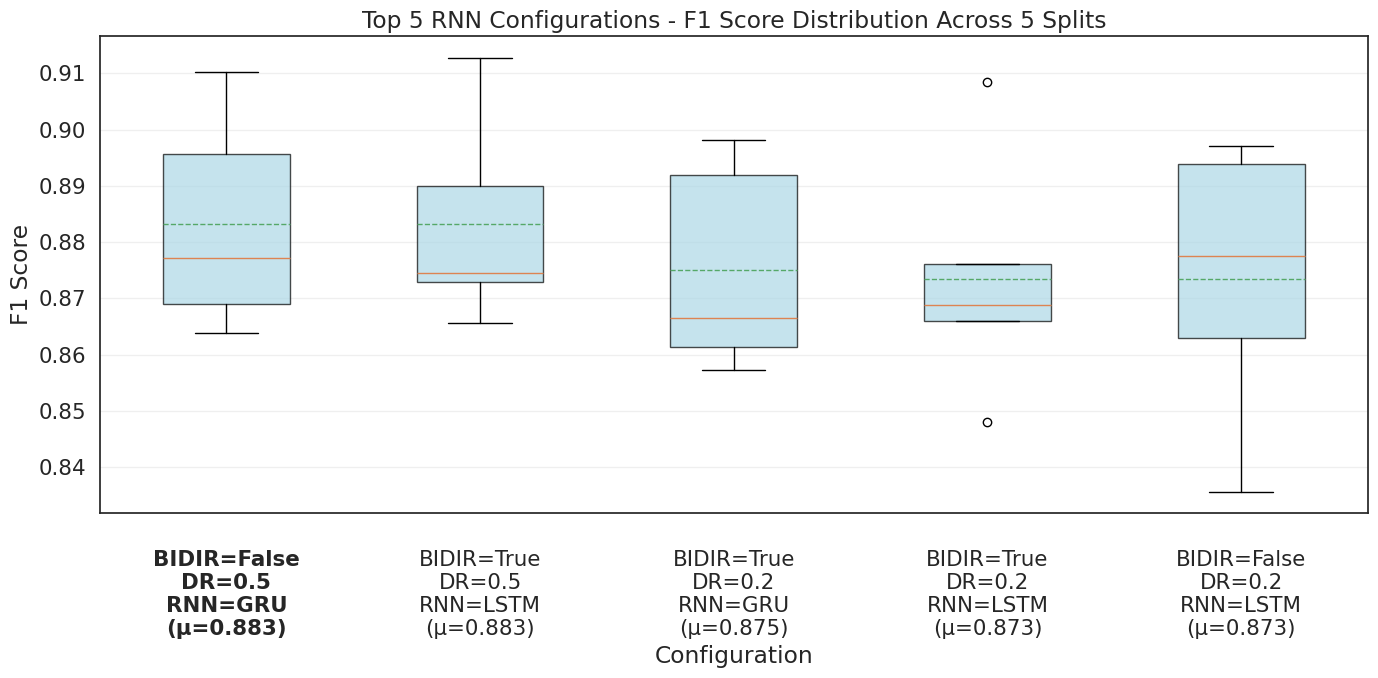

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# Gride search with
# fixed:
# GRU
# bidirectional: true
# dropout: 0.2
# variab:
# l1: 0.01,0.001
# l2: 0.01,0.001
# --> best score: 0.001,0.001, (0.01 is worst in any case for both, much worst)

# Grid search with
# fixed params: Stride=10, Window=80, learning_rate: 1e-3, l1=l2=0.001
# params_grid:
# model: GRU, RNN, LSTM
# bidirection: True, False
# dropouts: 0.2,0.5
#



In [21]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 80        # Input window size
STRIDE = 5              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.4       # Dropout probability
L1_LAMBDA = 0.001            # L1 penalty
L2_LAMBDA = 0.001            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'window_size': [20, 80],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'bidirectional':  BIDIRECTIONAL,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'rnn_type': RNN_TYPE,
    'learning_rate': LEARNING_RATE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'val_percent': VAL_PERCENT,
    'test_percent': TEST_PERCENT,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/2:
  window_size: 20
Training 500 epochs...
Early stopping triggered after 131 epochs.
Best model restored from epoch 81 with val_f1 0.8541
Training 500 epochs...
Early stopping triggered after 221 epochs.
Best model restored from epoch 171 with val_f1 0.8463
Training 500 epochs...
Early stopping triggered after 180 epochs.
Best model restored from epoch 130 with val_f1 0.8677
Training 500 epochs...
Early stopping triggered after 172 epochs.
Best model restored from epoch 122 with val_f1 0.8491
Training 500 epochs...


In [ ]:
# Search the best regularization params
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 80        # Input window size
STRIDE = 5              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.4       # Dropout probability
L1_LAMBDA = 0.001            # L1 penalty
L2_LAMBDA = 0.001            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'l1_lambda': [0.01, 2*0.001],
    'l2_lambda': [0.01, 2*0.001],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'bidirectional':  BIDIRECTIONAL,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'rnn_type': RNN_TYPE,
    'window_size': WINDOW_SIZE,
    'learning_rate': LEARNING_RATE,
    'dropout_rate': DROPOUT_RATE,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'val_percent': VAL_PERCENT,
    'test_percent': TEST_PERCENT,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 80        # Input window size
STRIDE = 10              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.4       # Dropout probability
L1_LAMBDA = 0.001            # L1 penalty
L2_LAMBDA = 0.001            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'hidden_layers': [2, 3, 4],
    'hidden_size': [64],
    'rnn_type': ['GRU','LSTM'],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'stride': STRIDE,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'bidirectional':  BIDIRECTIONAL,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'window_size': WINDOW_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'val_percent': VAL_PERCENT,
    'test_percent': TEST_PERCENT,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/6:
  hidden_layers: 2
  hidden_size: 64
  rnn_type: GRU
Training 500 epochs...
Early stopping triggered after 275 epochs.
Best model restored from epoch 225 with val_f1 0.8848
Training 500 epochs...
Early stopping triggered after 275 epochs.
Best model restored from epoch 225 with val_f1 0.8535
Training 500 epochs...
Early stopping triggered after 152 epochs.
Best model restored from epoch 102 with val_f1 0.8326
Training 500 epochs...
Early stopping triggered after 74 epochs.
Best model restored from epoch 24 with val_f1 0.8023
Training 500 epochs...
Early stopping triggered after 323 epochs.
Best model restored from epoch 273 with val_f1 0.8701
  NEW BEST SCORE!
  F1 Score: 0.8487±0.0289

Configuration 2/6:
  hidden_layers: 2
  hidden_size: 64
  rnn_type: LSTM
Training 500 epochs...
Early stopping triggered after 179 epochs.
Best model restored from epoch 129 with val_f1 0.8480
Training 500 epochs...
Early stopping triggered after 182 epochs.
Best model restored from 

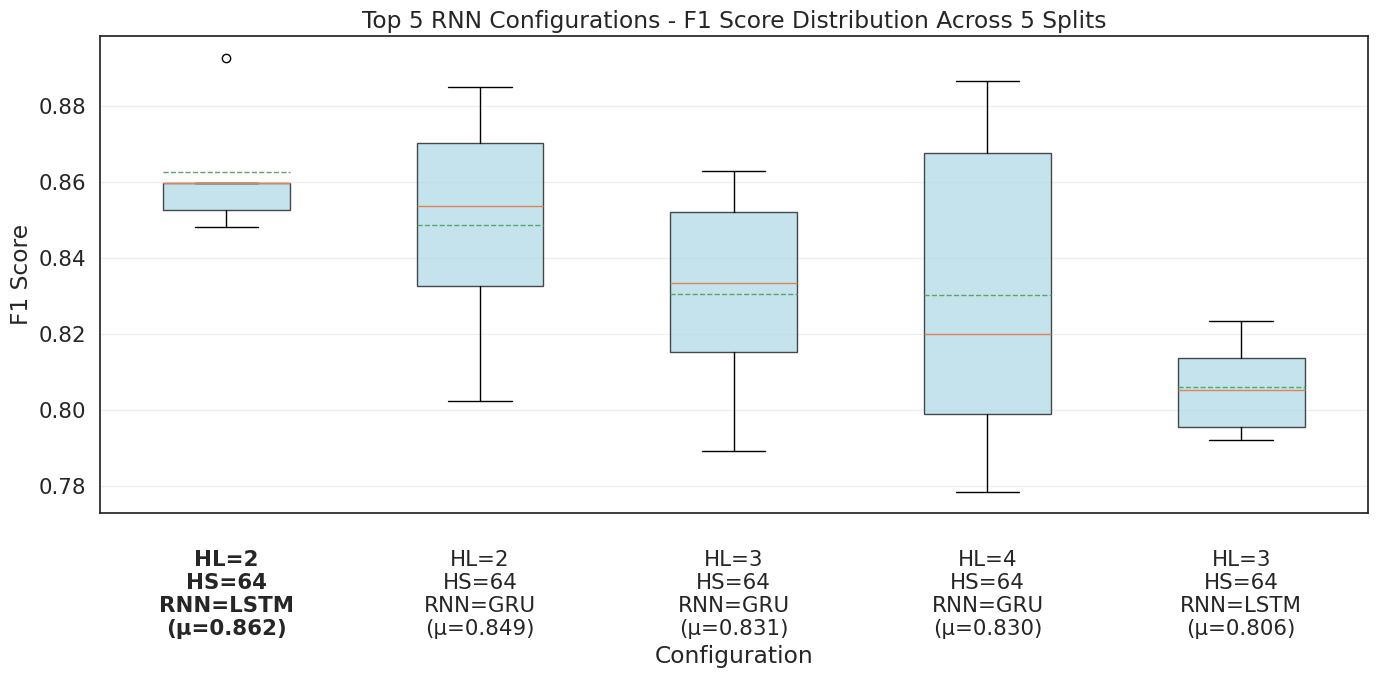

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)